# <span style="color:purple"> Markowitz solution: Evaluation of the most constervative call option price </span>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pricing import EquityForwardCurve, ForwardVariance, DiscountingCurve,piecewise_function,Vanilla_PayOff,PricingModel
from scipy import exp, sqrt, log
from scipy.interpolate import interp1d
import time, sys
from montecarlo import MC_Analisys, MC
from matplotlib import ticker
from targetvol import time_grid_union, Drift, CholeskyTDependent, Strategy,TVSForwardCurve ,TargetVolatilityStrategy,TargetVolatilityEuler,Markowitz_solution,loss_function
from numpy.linalg import cholesky

## Four Equities

#### market data

In [2]:
N_equity = 4                                #number of equities
T_max = 10
t = 0.                                      #pricing date
spot_price = np.array([110,120,97,133])            #spot price of the two assets
corr = np.array(([1,0.15,0.10,0.20],[0.15,1.,-0.05,0.18],[0.1,-0.05,1.,0.13],[0.20,0.18,0.13,1]))       #correlation matrix
minus = 1
"""Market Discount factors"""
r_t = np.array([1,1.9,1.2])/100            
T_discounts = np.array([3,6.,T_max])      #data observation of the market discounts factor
market_discounts = exp(-r_t*T_discounts)       #market discounts factor

"""Market repo rates"""  #https://tradingeconomics.com/united-states/repo-rate
T_repo1 = np.array([2,6,T_max])       #data observation of the market repo rates for equity 1
repo_rate1 = minus*np.array([0.32,0.35,0.33])/100  #market repo rates for equity 1


T_repo2 = np.array([3.,6.,T_max])
repo_rate2 = minus*np.array([0.21,0.2,0.25])/100

T_repo3 = np.array([2.,5.,T_max])
repo_rate3 = minus*np.array([0.1,0.17,0.199])/100

T_repo4 = np.array([5,T_max])
repo_rate4 = minus*np.array([0.2,0.24])/100


for i in range(N_equity):                   #dimensional check between time and market data
    a = globals()["repo_rate" + str(i+1)]
    b = globals()["T_repo" + str(i+1)]
    if(a.shape!=b.shape):
        raise Exception("WARNING: Different dimension between data and value for repo rates of asset "+str(i+1))
        
"""Spot Volatilities"""
sigma1 = np.array([20,20.6,22])/100
T_sigma1 = np.array([2,5.,T_max])
K1 = np.array([spot_price[0],200])
spot_vola1 = np.array((sigma1,sigma1))                                      #market implied volatility matrix

sigma2 = np.array([30,31,32.62])/100
T_sigma2 =  np.array([2.,6,T_max])
K2 = np.array([spot_price[1],200])
spot_vola2 = np.array((sigma2,sigma2))  

sigma3 = np.array([25,23,22])/100
T_sigma3 = np.array([3,7.,T_max])
K3 = np.array([spot_price[2],200])
spot_vola3 = np.array((sigma3,sigma3))  

sigma4 = np.array([15,16,14])/100
T_sigma4 =  np.array([2,6.,T_max])
K4 = np.array([spot_price[3],200])
spot_vola4 = np.array((sigma4,sigma4))  

for i in range(N_equity):                   #dimensional check between time and market data
    a = globals()["sigma" + str(i+1)]
    b = globals()["T_sigma" + str(i+1)]
    if(a.shape!=b.shape):
        raise Exception("WARNING: Different dimension between data and value for volatility of asset "+str(i+1))

#### Loading Discouting curve, Forward curve and forward variance matrix

In [3]:
D = DiscountingCurve(reference=t, discounts=market_discounts,dates=T_discounts)
F = np.array([])
V = np.array([])
for i in range(N_equity):
    q = globals()["repo_rate" + str(i+1)]
    T_q = globals()["T_repo" + str(i+1)]
    s_vola = globals()["spot_vola" + str(i+1)]
    T_vola = globals()["T_sigma" + str(i+1)]
    K = globals()["K" + str(i+1)]
    F = np.append(F,EquityForwardCurve(reference=t,spot=spot_price[i],discounting_curve=D,repo_dates=T_q,repo_rates=q))
    V = np.append(V,ForwardVariance(reference=t,spot_volatility=s_vola,strikes=K,maturities=T_vola,strike_interp=spot_price[i]))

Forward interest rate time grid [ 3.  6. 10.]
Forward interest rate:  [0.01   0.028  0.0015]
Forward repo time grid [ 2  6 10]
Forward repo rate:  [0.0032  0.00365 0.003  ]
Forward volatility time grid:  [ 2.  5. 10.]
Forward volatility:  [0.2        0.20990474 0.23316089]
Forward repo time grid [ 3.  6. 10.]
Forward repo rate:  [0.0021  0.0019  0.00325]
Forward volatility time grid:  [ 2.  6. 10.]
Forward volatility:  [0.3        0.31488093 0.34909325]
Forward repo time grid [ 2.  5. 10.]
Forward repo rate:  [0.001      0.00216667 0.00228   ]
Forward volatility time grid:  [ 3.  7. 10.]
Forward volatility:  [0.25       0.21377558 0.19467922]
Forward repo time grid [ 5 10]
Forward repo rate:  [0.002  0.0028]
Forward volatility time grid:  [ 2.  6. 10.]
Forward volatility:  [0.15       0.16477257 0.1029563 ]


In [4]:
mu = Drift(F)
nu = CholeskyTDependent(V,corr)
alpha = Strategy()

Drift time grid: [ 2.  3.  5.  6. 10.]
Drift values: [[0.0032     0.0021     0.001      0.002     ]
 [0.00365    0.0021     0.00216667 0.002     ]
 [0.00365    0.0019     0.00216667 0.002     ]
 [0.00365    0.0019     0.00228    0.0028    ]
 [0.003      0.00325    0.00228    0.0028    ]]
Cholesky covariance-variance time grid: [ 2.  3.  5.  6.  7. 10.]
Cholesky covariance-variance matrix values: [[[ 0.2         0.20990474  0.20990474  0.23316089  0.23316089
    0.23316089]
  [ 0.          0.          0.          0.          0.
    0.        ]
  [ 0.          0.          0.          0.          0.
    0.        ]
  [ 0.          0.          0.          0.          0.
    0.        ]]

 [[ 0.045       0.04723214  0.04723214  0.04723214  0.05236399
    0.05236399]
  [ 0.2966058   0.31131837  0.31131837  0.31131837  0.34514361
    0.34514361]
  [ 0.          0.          0.          0.          0.
    0.        ]
  [ 0.          0.          0.          0.          0.
    0.        ]]

 [[ 0

### uncostrained optimization

In [5]:
alpha.Mark_strategy(mu=mu,nu=nu)

Markowitz strategy time grid : [ 2.  3.  5.  6.  7. 10.]
Markowitz strategy :  [[-3.45517178 -0.56731187 -0.31913128 -3.39656999]
 [-3.38577698 -0.520106   -1.23006044 -2.27907558]
 [-3.3100412  -0.42874694 -1.73432789 -2.21165431]
 [-2.26279466 -0.32012128 -1.63492707 -3.55012741]
 [-0.97766287 -0.42150242 -1.12886293 -8.00955464]
 [-0.95506928 -0.42664409 -1.41552726 -7.89096267]]


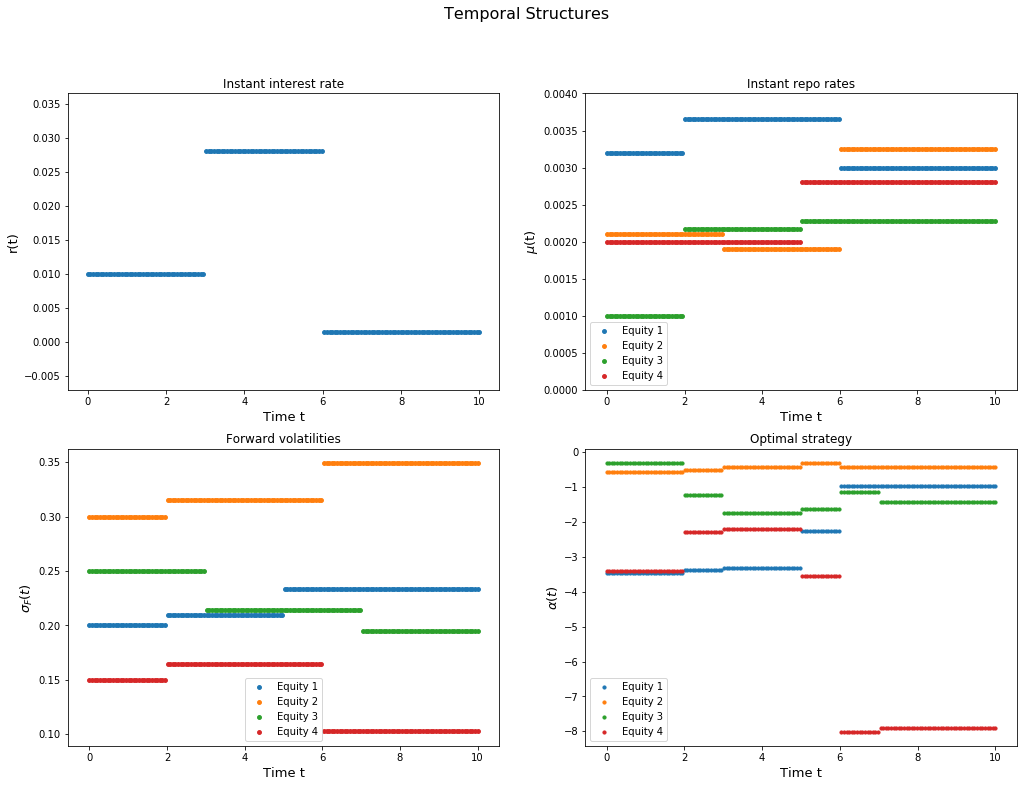

In [6]:
x = np.linspace(0,T_max-0.0001,150)
dimension_points = 15
plt.figure(figsize=(17,12))

plt.suptitle('Temporal Structures',fontsize=16) 

plt.subplot(2,2,1)
plt.scatter(x,piecewise_function(x,D.T,D.r),s=dimension_points)
plt.title('Instant interest rate')
plt.ylabel("r(t)", fontsize = 13)
plt.xlabel("Time t", fontsize = 13)
#plt.savefig("Instant_interest_rate.pdf")


plt.subplot(2,2,2)
for i in range(N_equity):
    plt.scatter(x,piecewise_function(x,F[i].T,F[i].q),label= "Equity "+str(i+1),s=dimension_points)
plt.legend()
plt.title('Instant repo rates')
plt.xlabel("Time t", fontsize = 13)
plt.ylabel(r"$\mu$(t)", fontsize = 13)
plt.ylim(0,0.004)
#plt.savefig("Instant_repo_rate.pdf")

plt.subplot(2,2,3)
plt.title('Forward volatilities')
for i in range(N_equity):
    plt.scatter(x,sqrt(V[i](x)),label= "Equity "+str(i+1),s=dimension_points)
plt.legend()
plt.xlabel("Time t",fontsize = 13)
plt.ylabel(r"$\sigma_{F}(t)$",fontsize = 13)
#plt.savefig("Forward_volatilities.pdf")

plt.subplot(2,2,4)
plt.title("Optimal strategy")
for i in range(N_equity):
    plt.scatter(x,piecewise_function(x,alpha.T,alpha.alpha_t.T[i]),label= "Equity "+str(i+1),s=10)
plt.legend()
plt.xlabel("Time t",fontsize=13)
plt.ylabel(r"$\alpha(t)$",fontsize =13)
#plt.savefig("optimal_strategy.pdf")
plt.show()

#### Simulation

In [7]:
I_0 = np.sum(spot_price)
vol = 1/N_equity*sqrt(np.sum(nu(0.)@nu(0.).T))
print("Target volatility: ",vol)
dates = alpha.T
dates = np.delete(dates,len(alpha.T)-1)
dates = np.append(dates,9.9)
K = I_0   #ATM pricing
simulations = 1e6
kind = 1 #call option
print("Spot price ",I_0)
print("Dates ",dates)

Target volatility:  0.13073111718332403
Spot price  460
Dates  [2.  3.  5.  6.  7.  9.9]


In [8]:
TVSF = TVSForwardCurve(reference = 0., vola_target =vol, spot_price = I_0, strategy = alpha, mu = mu,nu = nu, discounting_curve = D, fees = np.array([0,0]), fees_dates = np.array([0,T_max]))
TVS = TargetVolatilityStrategy(forward_curve=TVSF)
I_t = TVS.simulate(fixings = dates,Nsim=simulations, seed=10)
pay = Vanilla_PayOff(St=I_t,strike=K, typo=kind)*D(dates)
x, result_mark, result_err_mark = MC_Analisys(pay[:,len(dates)-1],100)

Forward curve at maturity:  535.0397563608648


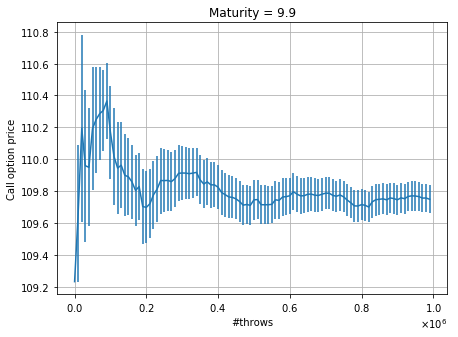

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.title("Maturity = "+str(round(dates[len(dates)-1],2)))
plt.errorbar(x,result_mark,yerr=result_err_mark)
plt.xlabel("#throws")
formatter = ticker.ScalarFormatter(useMathText=True) #scientific notation
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.xaxis.set_major_formatter(formatter)
#ax.yaxis.set_major_formatter(formatter)
plt.grid(True)
if kind ==1:
    plt.ylabel("Call option price")
#    plt.savefig("TVS_call_option_price.pdf")
if kind == -1:
    plt.ylabel("Put option price")
#    plt.savefig("TVS_put_option_price.pdf")
print("Forward curve at maturity: ",TVSF(dates[len(dates)-1]))    
plt.show()

/home/ste/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


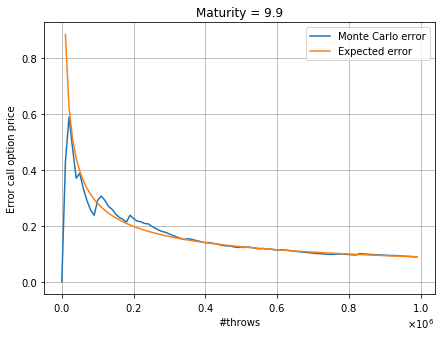

In [10]:
z = np.std(pay.T[len(dates)-1])
y = np.sqrt(x)
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.plot(x,result_err_mark, label = 'Monte Carlo error')
plt.plot(x,z/y, label = 'Expected error')
plt.xlabel("#throws")
plt.title("Maturity = "+str(round(dates[len(dates)-1],2)))
formatter = ticker.ScalarFormatter(useMathText=True) #scientific notation
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.xaxis.set_major_formatter(formatter)
plt.grid(True)
plt.legend()
if kind ==1:
    plt.ylabel("Error call option price")
    #plt.savefig("TVS_call_option_price_error.pdf")
if kind == -1:
    plt.ylabel("Error put option price")
    #plt.savefig("TVS_put_option_price_error.pdf")
plt.show()

In [11]:
n_grid = 500    #grid for the integration of the euler method (6000 for 1e6 good)
dates_euler = np.linspace(0.001,9.9,n_grid)

In [12]:
start_time = time.time()
Eulero = TargetVolatilityEuler(reference = 0., vola_target = vol, spot_price = I_0, strategy = alpha, mu = mu,nu = nu, discounting_curve = D, fees = np.array([0,0]), fees_dates = np.array([0.,T_max]))
I_t = Eulero.simulate(timegrid = dates_euler,Nsim=simulations, seed=10)
pay_euler = Vanilla_PayOff(St=I_t,strike=K,typo=kind)*D(dates_euler[len(dates_euler)-1])
x, result_euler, result_err_euler = MC_Analisys(pay_euler,100)
print("Execution time: ---%s min ---" %((time.time()-start_time)/60))

0
Execution time: ---2.000507203737895 min ---


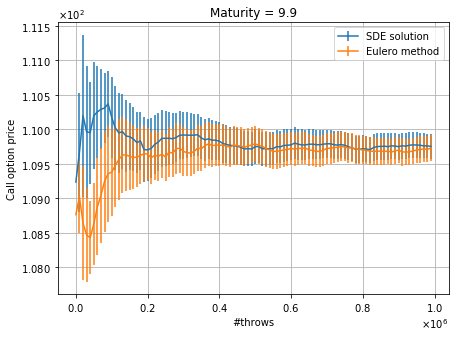

In [13]:
n_sigma = 2
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.title("Maturity = "+str(round(dates[len(dates)-1],2)))
plt.errorbar(x,result_mark,yerr=n_sigma*result_err_mark, label = "SDE solution")
plt.errorbar(x,result_euler,yerr=n_sigma*result_err_euler, label = "Eulero method")
plt.xlabel("#throws")
if kind ==1:
    plt.ylabel("Call option price")
if kind == -1:
    plt.ylabel("Put option price")
formatter = ticker.ScalarFormatter(useMathText=True) #scientific notation
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)
plt.grid(True)
plt.legend()
#plt.savefig("Markowitz_convergence_with_euler.pdf")
plt.show()

In [14]:
alpha.Intuitive_strategy1(forward_curves=F, maturity_date=T_max)
TVSF = TVSForwardCurve(reference = 0., vola_target =vol, spot_price = I_0, strategy = alpha, mu = mu,nu = nu, discounting_curve = D, fees = np.array([0,0]), fees_dates = np.array([0,T_max]))
TVS = TargetVolatilityStrategy(forward_curve=TVSF)
I_t = TVS.simulate(fixings= dates,Nsim=simulations, seed=10)
pay = Vanilla_PayOff(St=I_t,strike=K)*D(dates)
x, result_intuitive1, result_err_intuitive1 = MC_Analisys(pay[:,len(dates)-1],100)

Strategy time grid:  [ 0 10]
Intuitive strategy (invest all on the asset with maximum growth at maturity)  [[0. 0. 0. 1.]
 [0. 0. 0. 1.]]


In [15]:
alpha.Intuitive_strategy2(mu=mu)
TVSF = TVSForwardCurve(reference = 0., vola_target =vol, spot_price = I_0, strategy = alpha, mu = mu,nu = nu, discounting_curve = D, fees = np.array([0,0]), fees_dates = np.array([0,T_max]))
TVS = TargetVolatilityStrategy(forward_curve=TVSF)
I_t = TVS.simulate(fixings = dates,Nsim=simulations, seed=10)
pay = Vanilla_PayOff(St=I_t,strike=K)*D(dates)
x, result_intuitive2, result_err_intuitive2 = MC_Analisys(pay[:,len(dates)-1],100)

Strategy time grid:  [ 2.  3.  5.  6. 10.]
Intuitive strategy (invest all on the asset with minimum mu parameter) [[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]


In [16]:
alpha.Intuitive_strategy3(mu=mu,nu=nu)
TVSF = TVSForwardCurve(reference = 0., vola_target =vol, spot_price = I_0, strategy = alpha, mu = mu,nu = nu, discounting_curve = D, fees = np.array([0,0]), fees_dates = np.array([0,T_max]))
TVS = TargetVolatilityStrategy(forward_curve=TVSF)
I_t = TVS.simulate(fixings = dates,Nsim=simulations, seed=10)
pay = Vanilla_PayOff(St=I_t,strike=K)*D(dates)
x, result_intuitive3, result_err_intuitive3 = MC_Analisys(pay[:,len(dates)-1],100)

Strategy time grid:  [ 2.  3.  5.  6.  7. 10.]
Intuitive strategy (invest all on the asset with minimum mu/||nu|| parameter) [[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


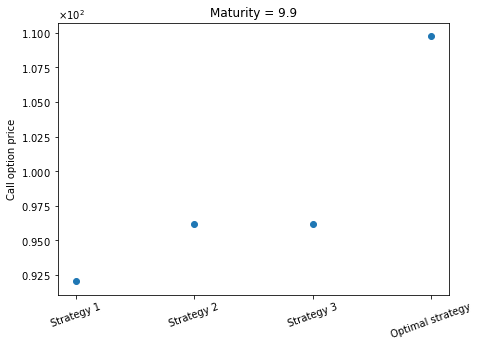

In [17]:
n =len(dates)-1
errori = np.array([result_err_intuitive1[99],result_err_intuitive2[99],result_err_intuitive3[99],result_err_mark[99]])
risultati = err = np.array([result_intuitive1[99],result_intuitive2[99],result_intuitive3[99],result_mark[99]])
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.xticks([1, 2, 3,4], ["Strategy 1","Strategy 2", "Strategy 3", "Optimal strategy"],rotation=20)  # Set text labels and properties.
plt.errorbar([1, 2, 3,4],risultati,errori,fmt='o')
plt.title("Maturity = "+str(round(dates[n],2)))
if kind ==1:
    plt.ylabel("Call option price")
if kind == -1:
    plt.ylabel("Put option price")
ax.yaxis.set_major_formatter(formatter)
#plt.savefig("strategy_comparison.pdf")
plt.show()

In [18]:
volatility_grid = np.arange(1,11)*0.05
alpha.Mark_strategy(mu=mu,nu=nu)
price = np.zeros(len(volatility_grid))
price_error = np.zeros(len(volatility_grid))
for i in range(len(volatility_grid)):
    TVSF = TVSForwardCurve(reference = 0., vola_target =volatility_grid[i], spot_price = I_0, strategy = alpha, mu = mu,nu = nu, discounting_curve = D, fees = np.array([0,0]), fees_dates = np.array([0,T_max]))
    TVS = TargetVolatilityStrategy(forward_curve=TVSF)
    I_t = TVS.simulate(fixings = dates,Nsim=simulations, seed=10)
    pay = Vanilla_PayOff(St=I_t,strike=K, typo=kind)*D(dates)
    price[i],price_error[i] = MC(pay.T[len(dates)-1])   

Markowitz strategy time grid : [ 2.  3.  5.  6.  7. 10.]
Markowitz strategy :  [[-3.45517178 -0.56731187 -0.31913128 -3.39656999]
 [-3.38577698 -0.520106   -1.23006044 -2.27907558]
 [-3.3100412  -0.42874694 -1.73432789 -2.21165431]
 [-2.26279466 -0.32012128 -1.63492707 -3.55012741]
 [-0.97766287 -0.42150242 -1.12886293 -8.00955464]
 [-0.95506928 -0.42664409 -1.41552726 -7.89096267]]


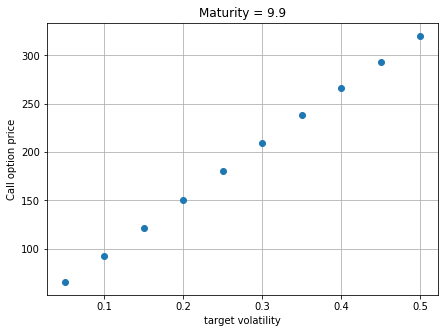

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.title("Maturity = "+str(round(dates[len(dates)-1],2)))
plt.errorbar(volatility_grid,price,yerr=price_error, fmt='o')
plt.xlabel("target volatility")
if kind ==1:
    plt.ylabel("Call option price")
if kind == -1:
    plt.ylabel("Put option price")
formatter = ticker.ScalarFormatter(useMathText=True) #scientific notation
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
#ax.xaxis.set_major_formatter(formatter)
#ax.yaxis.set_major_formatter(formatter)
plt.grid(True)
#plt.savefig("Markowitz_convergence_with_euler.pdf")
plt.show()

### Constrained optimization

In [20]:
I_0 = np.sum(spot_price)
vol = 1/N_equity*sqrt(np.sum(nu(0.)@nu(0.).T))
print("Target volatility: ",vol)
dates = alpha.T
dates = np.delete(dates,len(alpha.T)-1)
dates = np.append(dates,9.9)
K = I_0   #ATM pricing
simulations = 1e6
kind = 1 #call option
print("Spot price ",I_0)
print("Dates ",dates)

Target volatility:  0.13073111718332403
Spot price  460
Dates  [2.  3.  5.  6.  7.  9.9]


#### Constraint: 
### $$\sum_i \alpha_i = 1\quad \text{with}\quad \alpha_i>0$$

In [21]:
alpha.optimization_constrained(mu=mu, nu=nu, typo=1, N_trial=200)

Minumum: 0.0039999999999999645 at 31
Minumum: 0.006669187622198523 at 134
Minumum: 0.006034026896275101 at 143
Minumum: 0.006034026896275313 at 132
Minumum: 0.009309833296990732 at 159
Minumum: 0.009309833296990751 at 124
Optimal strategy time grid : [ 2.  3.  5.  6.  7. 10.]
Optimal strategy through minimization:  [[ 3.33682375e-17 -1.38777878e-15  1.00000000e+00  5.46299286e-18]
 [-9.97000081e-17  1.00000000e+00 -7.21644966e-16  1.07882930e-18]
 [ 3.15112518e-15  1.00000000e+00 -2.20517300e-17 -3.63042929e-14]
 [-5.99520433e-15  1.00000000e+00 -8.08597980e-16  4.13731549e-15]
 [ 7.19025329e-16  1.00000000e+00 -5.68989300e-15 -1.71011415e-17]
 [-2.23432384e-15  1.00000000e+00  2.77555756e-17  7.97972799e-17]]


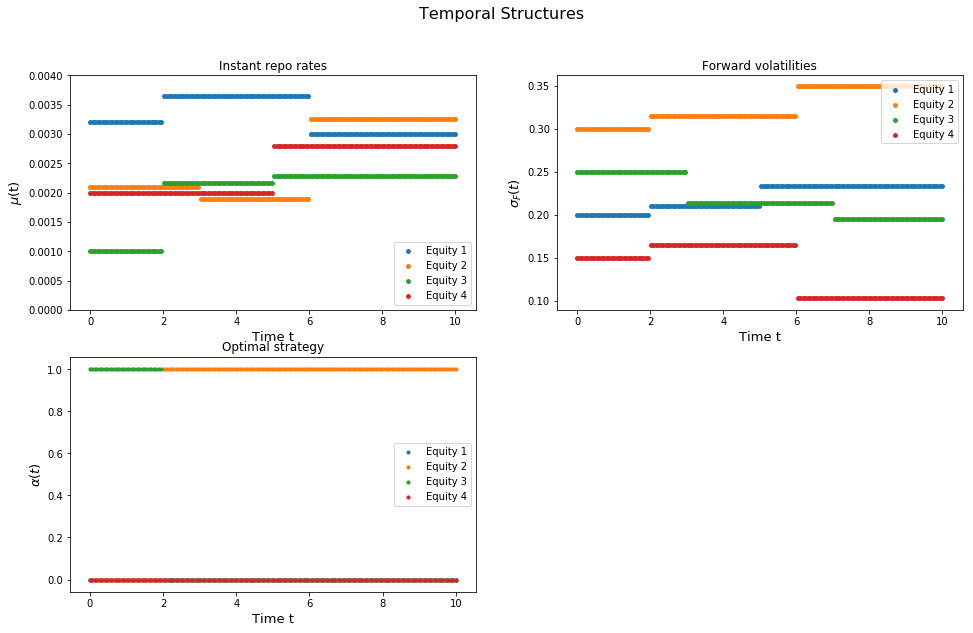

In [22]:
x = np.linspace(0,T_max-0.0001,150)
dimension_points = 15
plt.figure(figsize=(16,9.5))

plt.suptitle('Temporal Structures',fontsize=16) 


plt.subplot(2,2,1)
for i in range(N_equity):
    plt.scatter(x,piecewise_function(x,F[i].T,F[i].q),label= "Equity "+str(i+1),s=dimension_points)
plt.legend()
plt.title('Instant repo rates')
plt.xlabel("Time t", fontsize = 13)
plt.ylabel(r"$\mu$(t)", fontsize = 13)
plt.ylim(0,0.004)
#plt.savefig("Instant_repo_rate.pdf")

plt.subplot(2,2,2)
plt.title('Forward volatilities')
for i in range(N_equity):
    plt.scatter(x,sqrt(V[i](x)),label= "Equity "+str(i+1),s=dimension_points)
plt.legend()
plt.xlabel("Time t",fontsize = 13)
plt.ylabel(r"$\sigma_{F}(t)$",fontsize = 13)
#plt.savefig("Forward_volatilities.pdf")

plt.subplot(2,2,3)
plt.title("Optimal strategy")
for i in range(N_equity):
    plt.scatter(x,piecewise_function(x,alpha.T,alpha.alpha_t.T[i]),label= "Equity "+str(i+1),s=10)
plt.legend()
plt.xlabel("Time t",fontsize=13)
plt.ylabel(r"$\alpha(t)$",fontsize =13)
#plt.savefig("optimal_strategy.pdf")
plt.show()

In [23]:
TVSF = TVSForwardCurve(reference = 0., vola_target =vol, spot_price = I_0, strategy = alpha, mu = mu,nu = nu, discounting_curve = D, fees = np.array([0,0]), fees_dates = np.array([0,T_max]))
TVS = TargetVolatilityStrategy(forward_curve=TVSF)
I_t = TVS.simulate(fixings = dates,Nsim=simulations, seed=10)
pay = Vanilla_PayOff(St=I_t,strike=K, typo=kind)*D(dates)
x, result_constrain1, result_err_constrain1 = MC_Analisys(pay[:,len(dates)-1],100)

Forward curve at maturity:  513.9087057566516


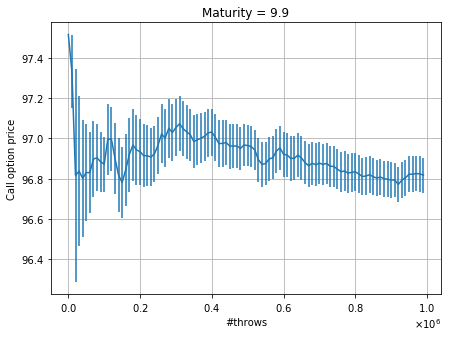

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.title("Maturity = "+str(round(dates[len(dates)-1],2)))
plt.errorbar(x,result_constrain1,yerr=result_err_constrain1)
plt.xlabel("#throws")
formatter = ticker.ScalarFormatter(useMathText=True) #scientific notation
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.xaxis.set_major_formatter(formatter)
#ax.yaxis.set_major_formatter(formatter)
plt.grid(True)
if kind ==1:
    plt.ylabel("Call option price")
#    plt.savefig("TVS_call_option_price.pdf")
if kind == -1:
    plt.ylabel("Put option price")
#    plt.savefig("TVS_put_option_price.pdf")
print("Forward curve at maturity: ",TVSF(dates[len(dates)-1]))    
plt.show()

#### Constraint: 
### $$\left|\alpha_i\right| \leq 25\%$$

In [25]:
alpha.optimization_constrained(mu=mu, nu=nu, typo=2, long_limit=25/100, N_trial=300)

Minumum: -0.01936017524196763 at 174
Minumum: -0.020673590469514013 at 122
Minumum: -0.02107728836745261 at 296
Minumum: -0.022535421389185954 at 95
Minumum: -0.029303431717927805 at 31
Minumum: -0.029573898617923918 at 131
Optimal strategy time grid : [ 2.  3.  5.  6.  7. 10.]
Optimal strategy through minimization:  [[-0.24989528 -0.04099273 -0.02305739 -0.24578299]
 [-0.25       -0.03841618 -0.09080557 -0.16821498]
 [-0.25       -0.03240987 -0.13103048 -0.16701422]
 [-0.15933096 -0.02254393 -0.1151362  -0.25      ]
 [-0.03050806 -0.0131488  -0.03521108 -0.2499626 ]
 [-0.03011812 -0.01344949 -0.04463276 -0.24874584]]


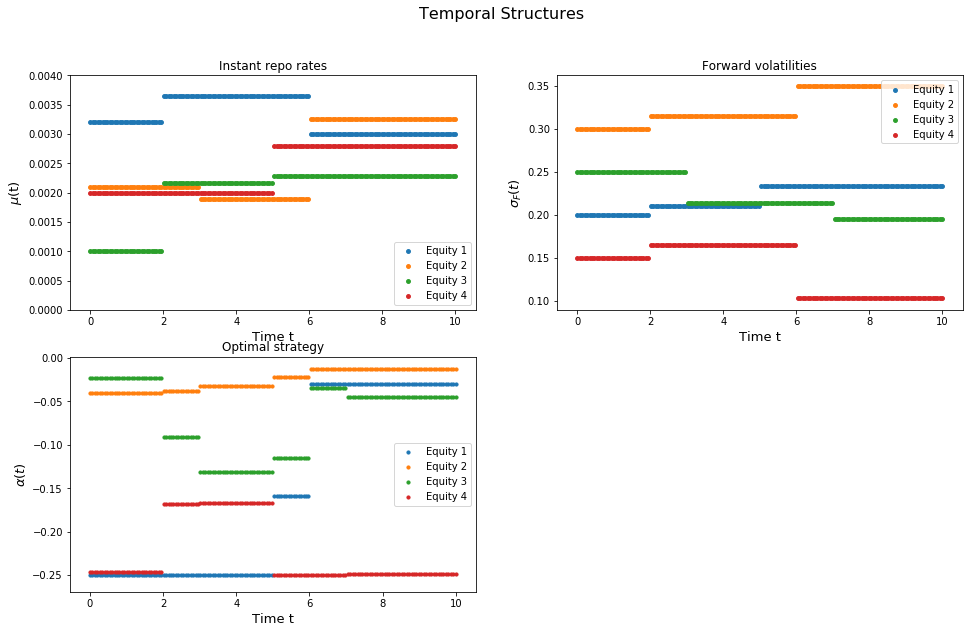

In [26]:
x = np.linspace(0,T_max-0.0001,150)
dimension_points = 15
plt.figure(figsize=(16,9.5))

plt.suptitle('Temporal Structures',fontsize=16) 


plt.subplot(2,2,1)
for i in range(N_equity):
    plt.scatter(x,piecewise_function(x,F[i].T,F[i].q),label= "Equity "+str(i+1),s=dimension_points)
plt.legend()
plt.title('Instant repo rates')
plt.xlabel("Time t", fontsize = 13)
plt.ylabel(r"$\mu$(t)", fontsize = 13)
plt.ylim(0,0.004)
#plt.savefig("Instant_repo_rate.pdf")

plt.subplot(2,2,2)
plt.title('Forward volatilities')
for i in range(N_equity):
    plt.scatter(x,sqrt(V[i](x)),label= "Equity "+str(i+1),s=dimension_points)
plt.legend()
plt.xlabel("Time t",fontsize = 13)
plt.ylabel(r"$\sigma_{F}(t)$",fontsize = 13)
#plt.savefig("Forward_volatilities.pdf")

plt.subplot(2,2,3)
plt.title("Optimal strategy")
for i in range(N_equity):
    plt.scatter(x,piecewise_function(x,alpha.T,alpha.alpha_t.T[i]),label= "Equity "+str(i+1),s=10)
plt.legend()
plt.xlabel("Time t",fontsize=13)
plt.ylabel(r"$\alpha(t)$",fontsize =13)
#plt.savefig("optimal_strategy.pdf")
plt.show()

In [27]:
TVSF = TVSForwardCurve(reference = 0., vola_target =vol, spot_price = I_0, strategy = alpha, mu = mu,nu = nu, discounting_curve = D, fees = np.array([0,0]), fees_dates = np.array([0,T_max]))
TVS = TargetVolatilityStrategy(forward_curve=TVSF)
I_t = TVS.simulate(fixings = dates,Nsim=simulations, seed=10)
pay = Vanilla_PayOff(St=I_t,strike=K, typo=kind)*D(dates)
x, result_constrain2, result_err_constrain2 = MC_Analisys(pay[:,len(dates)-1],100)

Forward curve at maturity:  535.0397561796605


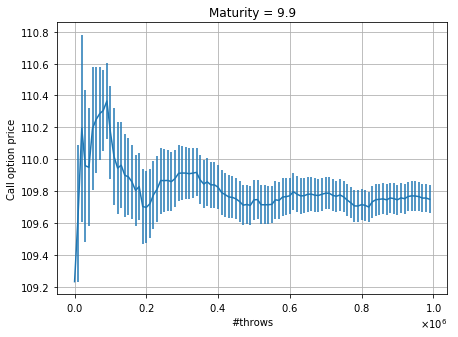

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.title("Maturity = "+str(round(dates[len(dates)-1],2)))
plt.errorbar(x,result_constrain2,yerr=result_err_constrain2)
plt.xlabel("#throws")
formatter = ticker.ScalarFormatter(useMathText=True) #scientific notation
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.xaxis.set_major_formatter(formatter)
#ax.yaxis.set_major_formatter(formatter)
plt.grid(True)
if kind ==1:
    plt.ylabel("Call option price")
#    plt.savefig("TVS_call_option_price.pdf")
if kind == -1:
    plt.ylabel("Put option price")
#    plt.savefig("TVS_put_option_price.pdf")
print("Forward curve at maturity: ",TVSF(dates[len(dates)-1]))    
plt.show()

#### Constraint: 
### $$\sum_i\alpha_i \leq 90\% \quad \text{for} \quad \alpha_i>0$$
### $$\left|\sum_i\alpha_i \right| \leq 10\% \quad \text{for} \quad \alpha_i<0$$

In [29]:
alpha.optimization_constrained(mu=mu, nu=nu, typo=3, long_limit=90/100,short_limit=10/100, N_trial=200)

Minumum: -0.019360175762994647 at 178
Minumum: -0.020673589390927796 at 195
Minumum: -0.021077288423346406 at 194
Minumum: -0.022535420546874456 at 6
Minumum: -0.02930343150354049 at 0
Minumum: -0.029573897185774703 at 28
Optimal strategy time grid : [ 2.  3.  5.  6.  7. 10.]
Optimal strategy through minimization:  [[-0.04140579 -0.00679751 -0.00381873 -0.0407046 ]
 [-0.04568071 -0.00701228 -0.01659278 -0.03071424]
 [-0.04308079 -0.00557787 -0.02256603 -0.02877531]
 [-0.02911603 -0.00412168 -0.02105544 -0.0456769 ]
 [-0.00928418 -0.0040002  -0.01070868 -0.07600694]
 [-0.00726743 -0.00325412 -0.01077316 -0.06009231]]


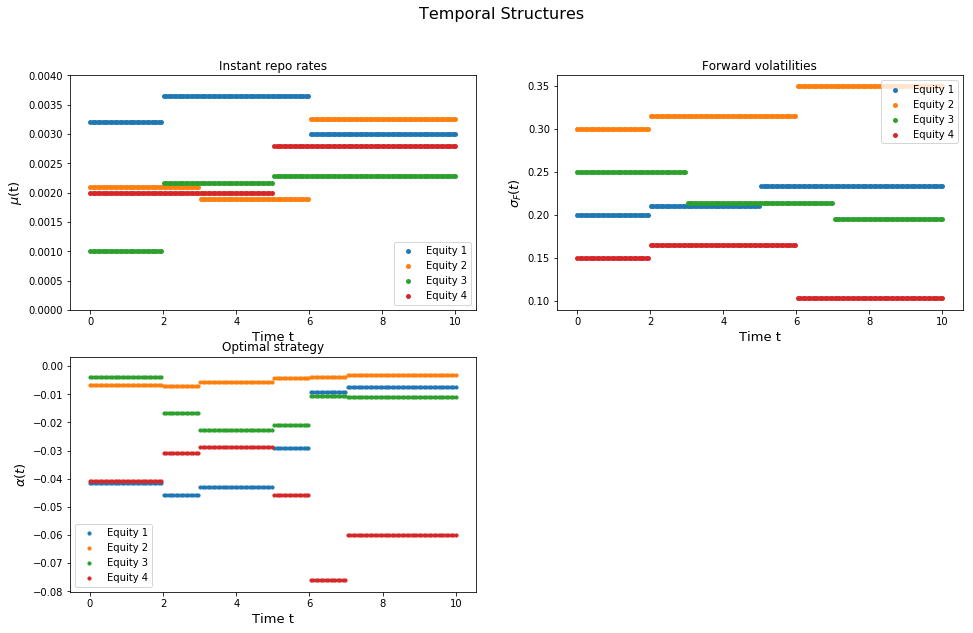

In [30]:
x = np.linspace(0,T_max-0.0001,150)
dimension_points = 15
plt.figure(figsize=(16,9.5))

plt.suptitle('Temporal Structures',fontsize=16) 


plt.subplot(2,2,1)
for i in range(N_equity):
    plt.scatter(x,piecewise_function(x,F[i].T,F[i].q),label= "Equity "+str(i+1),s=dimension_points)
plt.legend()
plt.title('Instant repo rates')
plt.xlabel("Time t", fontsize = 13)
plt.ylabel(r"$\mu$(t)", fontsize = 13)
plt.ylim(0,0.004)
#plt.savefig("Instant_repo_rate.pdf")

plt.subplot(2,2,2)
plt.title('Forward volatilities')
for i in range(N_equity):
    plt.scatter(x,sqrt(V[i](x)),label= "Equity "+str(i+1),s=dimension_points)
plt.legend()
plt.xlabel("Time t",fontsize = 13)
plt.ylabel(r"$\sigma_{F}(t)$",fontsize = 13)
#plt.savefig("Forward_volatilities.pdf")

plt.subplot(2,2,3)
plt.title("Optimal strategy")
for i in range(N_equity):
    plt.scatter(x,piecewise_function(x,alpha.T,alpha.alpha_t.T[i]),label= "Equity "+str(i+1),s=10)
plt.legend()
plt.xlabel("Time t",fontsize=13)
plt.ylabel(r"$\alpha(t)$",fontsize =13)
#plt.savefig("optimal_strategy.pdf")
plt.show()

In [31]:
TVSF = TVSForwardCurve(reference = 0., vola_target =vol, spot_price = I_0, strategy = alpha, mu = mu,nu = nu, discounting_curve = D, fees = np.array([0,0]), fees_dates = np.array([0,T_max]))
TVS = TargetVolatilityStrategy(forward_curve=TVSF)
I_t = TVS.simulate(fixings = dates,Nsim=simulations, seed=10)
pay = Vanilla_PayOff(St=I_t,strike=K, typo=kind)*D(dates)
x, result_constrain3, result_err_constrain3 = MC_Analisys(pay[:,len(dates)-1],100)

Forward curve at maturity:  535.0397558205091


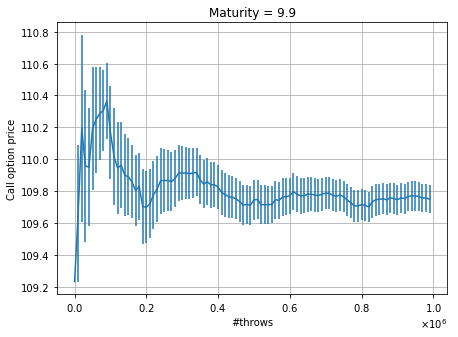

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.title("Maturity = "+str(round(dates[len(dates)-1],2)))
plt.errorbar(x,result_constrain3,yerr=result_err_constrain3)
plt.xlabel("#throws")
formatter = ticker.ScalarFormatter(useMathText=True) #scientific notation
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.xaxis.set_major_formatter(formatter)
#ax.yaxis.set_major_formatter(formatter)
plt.grid(True)
if kind ==1:
    plt.ylabel("Call option price")
#    plt.savefig("TVS_call_option_price.pdf")
if kind == -1:
    plt.ylabel("Put option price")
#    plt.savefig("TVS_put_option_price.pdf")
print("Forward curve at maturity: ",TVSF(dates[len(dates)-1]))    
plt.show()